### 1 - Imports and Initial Configurations

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

# Visualization settings for the plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

### 2 - Definition of the Simulated Environment (Pools, Rules, Costs, Weights)

In [10]:
# Pools and conditional rules for the "before" state
POOLS_BEFORE = {
    'enemies': {
        # Common Enemies (basic, low-cost, low-weight)
        'Zombie':             {'cost': 10, 'weight': 100, 'tags': ['Common', 'Undead', 'Physical']},
        'Skeleton Archer':    {'cost': 12, 'weight': 70,  'tags': ['Common', 'Undead', 'Physical', 'Ranged']},
        'Cave Spider':        {'cost': 11, 'weight': 75,  'tags': ['Common', 'Beast', 'Poison', 'Debuff_Speed']},
        'Bandit':             {'cost': 13, 'weight': 65,  'tags': ['Common', 'Human', 'Physical']},
        'Forest Wisp':        {'cost': 10, 'weight': 70,  'tags': ['Common', 'Magical', 'Illusion']},
        'Poisonous Mushroom': {'cost': 8,  'weight': 80,  'tags': ['Common', 'Beast', 'Poison', 'Debuff_Healing']},
        'Goblin':             {'cost': 9,  'weight': 90,  'tags': ['Common', 'Beast', 'Aggressive']},
        'Shadow Assassin':    {'cost': 15, 'weight': 50,  'tags': ['Common', 'Stealth', 'Debuff_Accuracy']},
        'Cursed Spirit':      {'cost': 14, 'weight': 55,  'tags': ['Common', 'Undead', 'Cursed', 'Debuff_Morale']},
        'Poisoned Rat':       {'cost': 7,  'weight': 85,  'tags': ['Common', 'Beast', 'Poison', 'Debuff_Speed']},
        'Giant Bat':          {'cost': 10, 'weight': 75,  'tags': ['Common', 'Beast', 'Aggressive']},
        'Cursed Zombie':      {'cost': 12, 'weight': 60,  'tags': ['Common', 'Undead', 'Cursed', 'Debuff_Morale']},
        'Dark Cultist':       {'cost': 16, 'weight': 40,  'tags': ['Common', 'Human', 'Magical', 'Debuff_Speed']},
        'Poisoned Scorpion':  {'cost': 9,  'weight': 80,  'tags': ['Common', 'Beast', 'Poison', 'Debuff_Speed']},
        'Cursed Knight':      {'cost': 18, 'weight': 30,  'tags': ['Common', 'Undead', 'Cursed', 'Physical', 'Tank']},
        'Shadow Lurker':      {'cost': 14, 'weight': 60,  'tags': ['Common', 'Stealth', 'Debuff_Accuracy']},
        'Wild Boar':          {'cost': 9,  'weight': 80,  'tags': ['Common', 'Beast', 'Physical', 'Aggressive']},

        # Bosses (heavy, high-cost, high-weight)
        'Lava Golem':         {'cost': 25, 'weight': 15,  'tags': ['Elite', 'Thermal', 'Area_Damage']},
        'Krul':               {'cost': 20, 'weight': 10,  'tags': ['Elite', 'Physical', 'Heavy']},
        'Laezarus':           {'cost': 22, 'weight': 5,   'tags': ['Elite', 'Tank', 'Defensive']},
        'A Thousand Cursed':  {'cost': 23, 'weight': 3,   'tags': ['Elite', 'Magical', 'Debuff_Speed']},
        'Queen Arachna':      {'cost': 48, 'weight': 6,   'tags': ['Boss', 'Beast', 'Poison', 'Summoner']},
        'Ashen Monarch':      {'cost': 52, 'weight': 4,   'tags': ['Boss', 'Thermal', 'Heat', 'Heavy']},
        'The Forgotten One':  {'cost': 55, 'weight': 3,   'tags': ['Boss', 'Undead', 'Magical', 'Cursed', 'Control']},

        # Elite Enemies (more challenging, with unique abilities)
        'Hopeless Agent':     {'cost': 40, 'weight': 5,   'tags': ['Boss', 'Undead', 'Summoner']},
        'Bedrose Gardener':   {'cost': 30, 'weight': 10,  'tags': ['Boss', 'Undead', 'Physical', 'Tank']},
        'Lich':               {'cost': 50, 'weight': 20,  'tags': ['Boss', 'Undead', 'Magical', 'Summoner']},
        'The Dark Knight':    {'cost': 45, 'weight': 15,  'tags': ['Boss', 'Undead', 'Physical', 'Tank']},
        'Kalisto':            {'cost': 35, 'weight': 5,   'tags': ['Boss', 'Beast', 'Aggressive', 'Heavy']},    
        'Berserker Spirit':   {'cost': 28, 'weight': 12,  'tags': ['Elite', 'Undead', 'Aggressive', 'Physical']},
        'Flesh Abomination':  {'cost': 32, 'weight': 8,   'tags': ['Elite', 'Undead', 'Cursed', 'Heavy']},
        'Twilight Stalker':   {'cost': 27, 'weight': 10,  'tags': ['Elite', 'Stealth', 'Control_Fear']},
            
        # None
        'None':               {'cost': 0,  'weight': 40,  'tags': []} 
    },

    'events': {
        # Common treasures (low cost, low weight)
        'Treasure':           {'cost': -5,  'weight': 50,  'tags': ['Reward', 'Common']},

        # Morbid Treasure: (high cost, high weight, atracts undead)
        'Morbid Treasure':    {'cost': -15, 'weight': 20,  'tags': ['Reward', 'Morbid']},

        # Traps (hazards, high cost, high weight)
        'Trap':               {'cost': 8,   'weight': 40,  'tags': ['Hazard', 'Physical']},

        # Cursed Altar: (high cost, high weight, cursed)
        'Cursed Altar':       {'cost': 5,   'weight': 25,  'tags': ['Hazard', 'Cursed', 'Morbid']},

        # Healing Fountain: (low cost, low weight, healing)
        'Fountain of Life':   {'cost': -10, 'weight': 25,  'tags': ['Reward', 'Healing', 'Sanctuary']},

        # Ambush: (surprise attack, high cost, high weight)
        'Ambush':             {'cost': 15,  'weight': 15,  'tags': ['Hazard', 'Surprise_Attack']},

        # Dark Pact: (high risk, high reward)
        'Dark Pact':          {'cost': 0,   'weight': 10,  'tags': ['Risk_Reward', 'Morbid']},
        
        # None
        'None':               {'cost': 0,   'weight': 80,  'tags': []}
    },

    'effects': {
        'Slow Terrain':       {'cost': 5,   'weight': 30,  'tags': ['Terrain', 'Debuff']},
        'Heat':               {'cost': 7,   'weight': 15,  'tags': ['Terrain', 'Thermal', 'Damage_Over_Time']},
        'Evasion Zone':       {'cost': -4,  'weight': 25,  'tags': ['Buff', 'Defensive']},
        'Dense Fog':          {'cost': 4,   'weight': 20,  'tags': ['Debuff', 'Visibility']},
        'Amplifying Field':   {'cost': -6,  'weight': 15,  'tags': ['Buff', 'Magical']},
        'Consecrated Ground': {'cost': -8,  'weight': 10,  'tags': ['Buff', 'Sanctuary', 'Healing']},
        
        # None
        'None':               {'cost': 0,   'weight': 100, 'tags': []}
    }
}

# Defining the content pools and conditional rules for the "before" state
CONDITIONAL_RULES_BEFORE = [
    # Elites shape the environment around them.
    {'if_tag': 'Elite', 'then_tag': 'Terrain', 'multiplier': 2.5},

    # Bosses guard macabre treasures.
    {'if_tag': 'Boss', 'then_tag': 'Morbid', 'multiplier': 3.0},

    # A small bonus for simpler encounters.
    {'if_tag': 'Common', 'then_tag': 'Buff', 'multiplier': 1.5},

    # Strong thematic synergy.
    {'if_tag': 'Thermal', 'then_tag': 'Heat', 'multiplier': 10.0},

    # Undead and curses go hand in hand.
    {'if_tag': 'Undead', 'then_tag': 'Cursed', 'multiplier': 4.0},

    # Wild beasts can ambush prey.
    {'if_tag': 'Beast', 'then_tag': 'Surprise_Attack', 'multiplier': 3.0},

    # Sacred places often provide healing.
    {'if_tag': 'Sanctuary', 'then_tag': 'Healing', 'multiplier': 5.0},

    # Hazards are rare in sacred places.
    {'if_tag': 'Sanctuary', 'then_tag': 'Hazard', 'multiplier': 0.1},

    # Undead avoid holy ground.
    {'if_tag': 'Sanctuary', 'then_tag': 'Undead', 'multiplier': 0.05},

    # Archers are less effective in fog.
    {'if_tag': 'Ranged', 'then_tag': 'Visibility', 'multiplier': 0.2},

    # Healing and hazards rarely coexist.
    {'if_tag': 'Healing', 'then_tag': 'Hazard', 'multiplier': 0.3},

        # Poison enemies thrive in fog and hinder healing.
    {'if_tag': 'Poison', 'then_tag': 'Healing', 'multiplier': 0.2},
    {'if_tag': 'Poison', 'then_tag': 'Visibility', 'multiplier': 2.0},

    # Control abilities synergize with Debuffs.
    {'if_tag': 'Control', 'then_tag': 'Debuff', 'multiplier': 3.0},

    # Stealth-based units favor low visibility.
    {'if_tag': 'Stealth', 'then_tag': 'Visibility', 'multiplier': 1.8},

    # Aggressive enemies are more common in wild terrains.
    {'if_tag': 'Aggressive', 'then_tag': 'Terrain', 'multiplier': 1.5},

    # Cursed creatures thrive in morbid settings.
    {'if_tag': 'Cursed', 'then_tag': 'Morbid', 'multiplier': 3.5},

    # Magical buffs intensify magical creatures.
    {'if_tag': 'Magical', 'then_tag': 'Magical', 'multiplier': 2.0},

    # Physical enemies are hindered by terrain effects.
    {'if_tag': 'Physical', 'then_tag': 'Terrain', 'multiplier': 0.6},

    # Humans are vulnerable to surprise attacks.
    {'if_tag': 'Human', 'then_tag': 'Surprise_Attack', 'multiplier': 2.2},

    # Illusions distort visibility and debuff perception.
    {'if_tag': 'Illusion', 'then_tag': 'Visibility', 'multiplier': 2.5},

    # Burn effects intensify in thermal environments.
    {'if_tag': 'Heat', 'then_tag': 'Thermal', 'multiplier': 4.0},

    # Summoners benefit from magical buffs.
    {'if_tag': 'Summoner', 'then_tag': 'Buff', 'multiplier': 1.8}
]

# Defining the content pools and conditional rules for the "after" state
with open("../data/enemies_and_events.yaml", "r", encoding="utf-8") as file:
    enemies_and_events_data = yaml.safe_load(file)

POOLS_BEFORE = enemies_and_events_data["pools"]
CONDITIONAL_RULES_BEFORE = enemies_and_events_data["conditional_rules"]

import copy
POOLS_AFTER = copy.deepcopy(POOLS_BEFORE)
#POOLS_AFTER['enemies']['Bedrose Gardener'] = {'cost': 10, 'weight': 65, 'tags': ['Common']}

CONDITIONAL_RULES_AFTER = copy.deepcopy(CONDITIONAL_RULES_BEFORE)
# New synergy rule for the added content
# CONDITIONAL_RULES_AFTER.append(
    
# )

### 3 - Implementation of the Content Generation Function

In [4]:
def draw_item(pool, current_budget, tag_context, rules):
    valid_items = []
    adjusted_weights = []

    for name, attributes in pool.items():
        if attributes['cost'] <= current_budget:
            final_weight = attributes['weight']
            # Apply conditional rules
            for rule in rules:
                if rule['if_tag'] in tag_context and rule['then_tag'] in attributes['tags']:
                    final_weight *= rule['multiplier']
            
            valid_items.append(name)
            adjusted_weights.append(final_weight)

    if not valid_items:
        # The original code had 'Nenhum' which was translated to 'None'.
        # This assumes a 'None' key exists in every pool as a fallback.
        return 'None', pool['None']

    # Normalize the weights to create a probability distribution
    weight_sum = sum(adjusted_weights)
    probabilities = [p / weight_sum for p in adjusted_weights]

    # Draw an item based on the adjusted weights
    choice = np.random.choice(valid_items, p=probabilities)
    return choice, pool[choice]


def generate_room_content(k, T, pools, rules):
    # Initial budget increases with depth k
    initial_budget = 10 + k * 2.5
    
    tag_context = set()
    result = {}

    # 1. Draw Enemy
    enemy_name, enemy = draw_item(pools['enemies'], initial_budget, tag_context, rules)
    result['enemy'] = enemy_name
    tag_context.update(enemy['tags'])
    remaining_budget_1 = initial_budget - enemy['cost']

    # 2. Draw Event
    event_name, event = draw_item(pools['events'], remaining_budget_1, tag_context, rules)
    result['event'] = event_name
    tag_context.update(event['tags'])
    remaining_budget_2 = remaining_budget_1 - event['cost']

    # 3. Draw Effect
    effect_name, effect = draw_item(pools['effects'], remaining_budget_2, tag_context, rules)
    result['effect'] = effect_name
    
    result['total_cost'] = (enemy['cost'] + event['cost'] + effect['cost'])
    return result

### 4 - Implementation of the Simulation Function

In [5]:
def run_simulation(pools, rules, n_simulations=10000):
    data = []
    for k_sim in range(1, 11):
        for _ in range(n_simulations // 10):
            room = generate_room_content(k=k_sim, T='standard', pools=pools, rules=rules)
            room['k'] = k_sim
            data.append(room)
    return pd.DataFrame(data)

### 5 - Simulation Before and After the New Addition

In [6]:
print("Starting simulations...")
df_before = run_simulation(POOLS_BEFORE, CONDITIONAL_RULES_BEFORE)
print("'BEFORE' simulation complete.")
df_after = run_simulation(POOLS_AFTER, CONDITIONAL_RULES_AFTER)
print("'AFTER' simulation complete.")

Starting simulations...
'BEFORE' simulation complete.
'AFTER' simulation complete.


### 6 - Analysis and Visualization Functions

In [7]:
def analyze_frequency(df_before, df_after, column):
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
    
    df_before[column].value_counts(normalize=True).plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title(f'Frequency Distribution (BEFORE) - {column}')
    axes[0].set_ylabel('Relative Frequency')
    
    df_after[column].value_counts(normalize=True).plot(kind='bar', ax=axes[1], color='salmon')
    axes[1].set_title(f'Frequency Distribution (AFTER) - {column}')
    
    plt.suptitle(f'Frequency Analysis for Category: {column.upper()}', fontsize=16)
    plt.show()

def analyze_cost(df_before, df_after):
    plt.figure(figsize=(12, 7))
    sns.kdeplot(df_before['total_cost'], label='BEFORE', color='skyblue', fill=True)
    sns.kdeplot(df_after['total_cost'], label='AFTER', color='salmon', fill=True)
    plt.title('Distribution of Total Cost per Room (Difficulty)')
    plt.xlabel('Total Cost')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def analyze_cooccurrence(df, title):
    cooc = pd.crosstab(df['enemy'], df['effect'])
    plt.figure(figsize=(10, 8))
    sns.heatmap(cooc, annot=True, fmt='d', cmap='viridis')
    plt.title(f'Enemy x Effect Co-occurrence Matrix ({title})')
    plt.show()

def calculate_info_metrics(df, col1, col2):
    # Marginal Entropy H(X)
    p_x = df[col1].value_counts(normalize=True)
    h_x = entropy(p_x, base=2)

    # Marginal Entropy H(Y)
    p_y = df[col2].value_counts(normalize=True)
    h_y = entropy(p_y, base=2)

    # Joint Entropy H(X, Y)
    p_xy = df.groupby([col1, col2]).size() / len(df)
    h_xy = entropy(p_xy, base=2)

    # Mutual Information I(X; Y) = H(X) + H(Y) - H(X,Y)
    i_xy = h_x + h_y - h_xy

    return {'H(col1)': h_x, 'H(col2)': h_y, 'H(col1,col2)': h_xy, 'I(col1;col2)': i_xy}


### 7 - Analysis of the Generator Function After the Addition

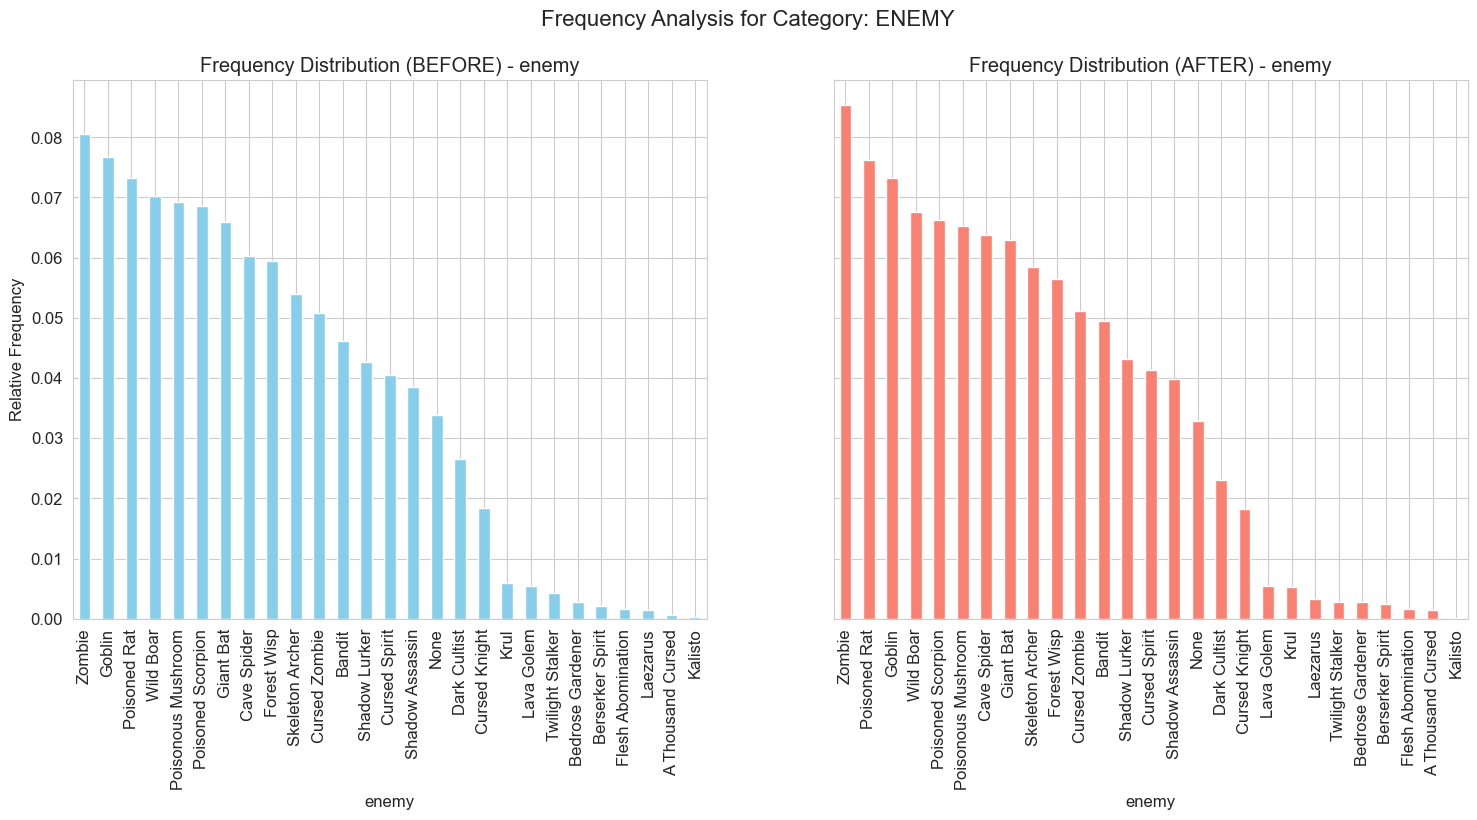

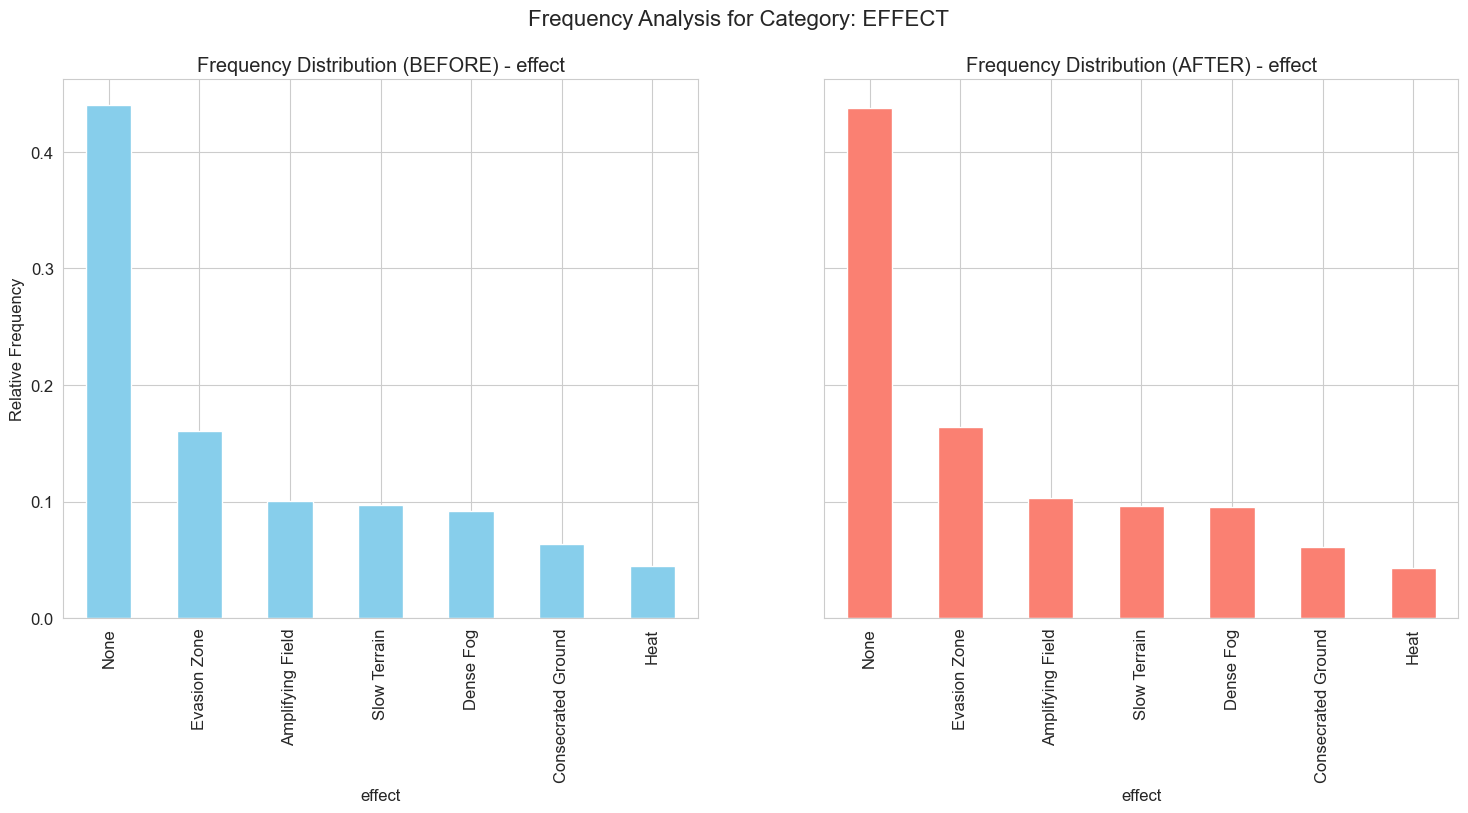

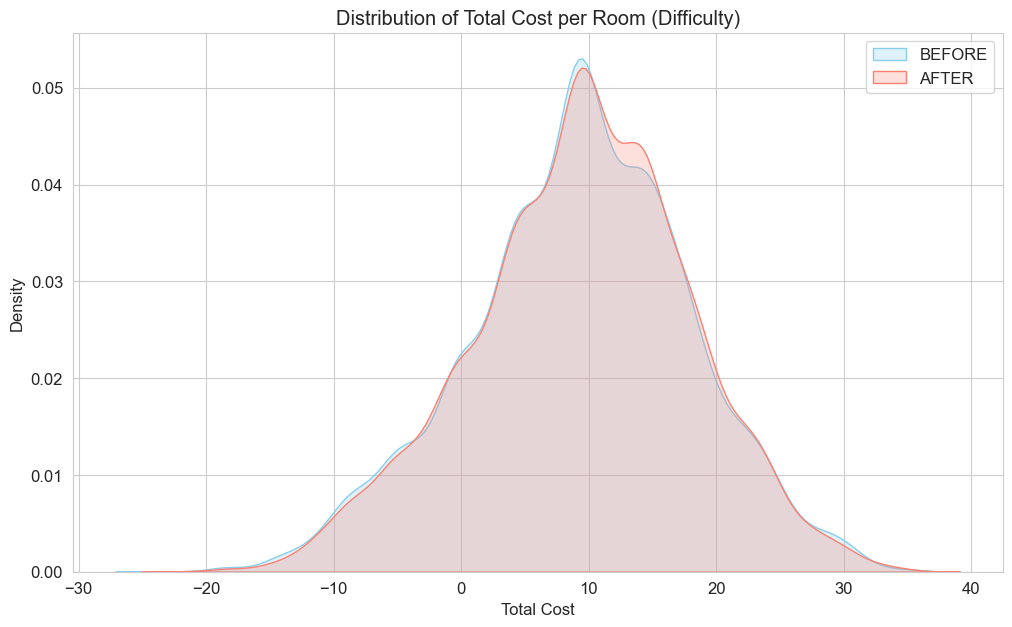

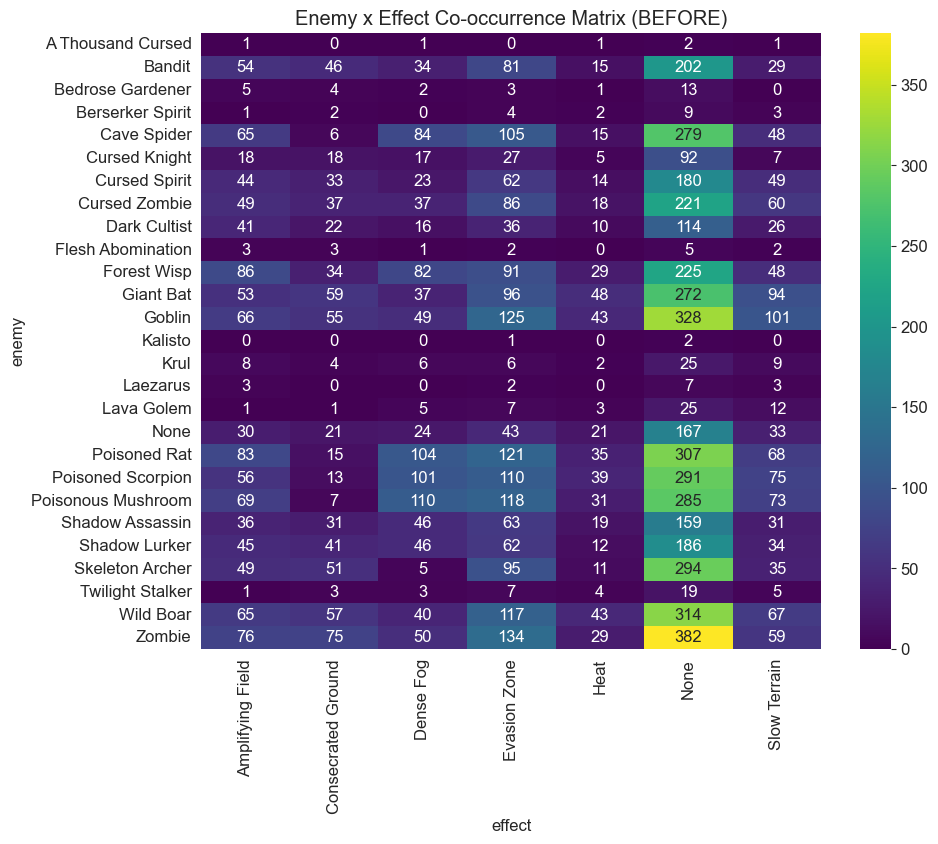

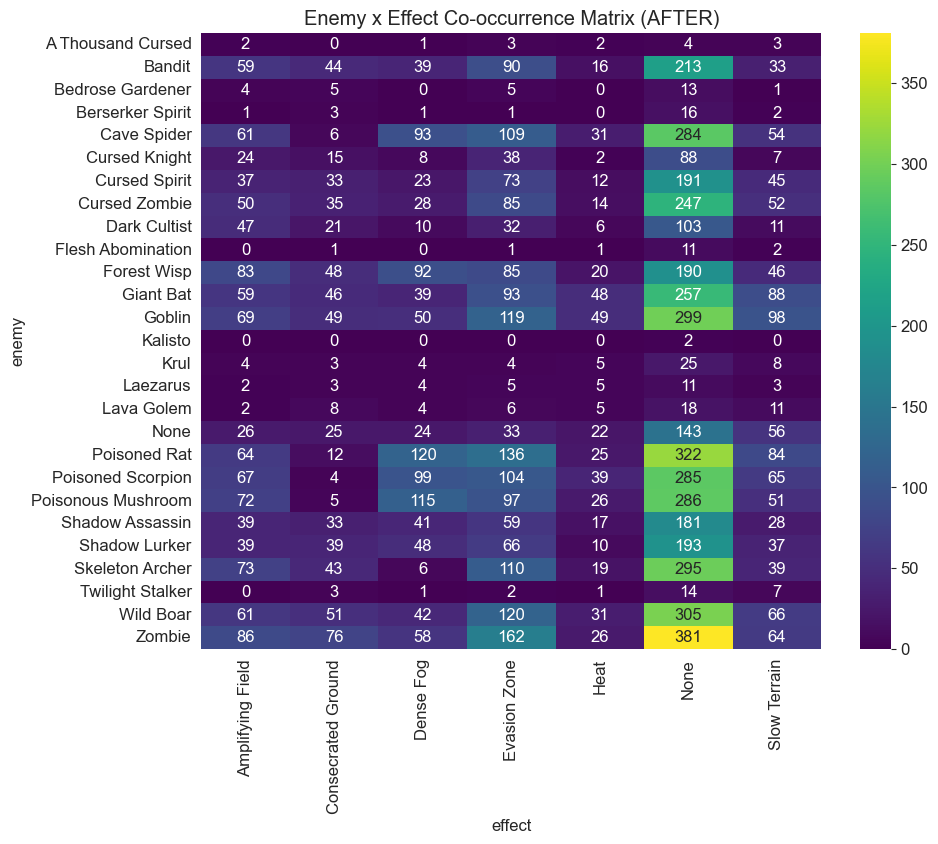



--- IMPACT CONTROL PANEL ---

                      Metric  Value BEFORE  Value AFTER  Change (%)
          Average Total Cost        9.2642       9.4197      1.6785
          Entropy H(Enemies)        4.2215       4.2246      0.0751
          Entropy H(Effects)        2.3770       2.3768     -0.0091
Mutual Info I(Enemy; Effect)        0.0466       0.0579     24.0615


In [8]:
# Frequency Analysis for Enemies and Effects
analyze_frequency(df_before, df_after, 'enemy')
analyze_frequency(df_before, df_after, 'effect')

# Total Cost Analysis
analyze_cost(df_before, df_after)

# Co-occurrence Analysis
analyze_cooccurrence(df_before, 'BEFORE')
analyze_cooccurrence(df_after, 'AFTER')

# Quantitative Summary Calculation and Presentation
metrics_before = calculate_info_metrics(df_before, 'enemy', 'effect')
metrics_after = calculate_info_metrics(df_after, 'enemy', 'effect')

summary = pd.DataFrame({
    'Metric': ['Average Total Cost', 'Entropy H(Enemies)', 'Entropy H(Effects)', 'Mutual Info I(Enemy; Effect)'],
    'Value BEFORE': [
        df_before['total_cost'].mean(),
        metrics_before['H(col1)'],
        metrics_before['H(col2)'],
        metrics_before['I(col1;col2)']
    ],
    'Value AFTER': [
        df_after['total_cost'].mean(),
        metrics_after['H(col1)'],
        metrics_after['H(col2)'],
        metrics_after['I(col1;col2)']
    ]
})

summary['Change (%)'] = ((summary['Value AFTER'] / summary['Value BEFORE']) - 1) * 100

print("\n\n--- IMPACT CONTROL PANEL ---\n")
print(summary.to_string(index=False, float_format="%.4f"))